In [1]:
# Establish the Working Directory
import os

# Print current working directory before change
os.getcwd()

'C:\\Users\\datam'

In [2]:
# Change the Directory
os.chdir("C:\\Users\\datam\\OneDrive\\Desktop\\python") # change as needed

# Verify the change
os.getcwd()

'C:\\Users\\datam\\OneDrive\\Desktop\\python'

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, confusion_matrix, log_loss
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import scorecardpy as sc
import seaborn as sns

In [4]:
# Read the data
santander = pd.read_csv("santander.csv")

In [6]:
# Check target distribution
santander['y'].value_counts()

y
0    73012
1     3008
Name: count, dtype: int64

In [7]:
santander.duplicated().value_counts()

False    71192
True      4828
Name: count, dtype: int64

In [8]:
# Remove the duplicates
santander = santander.drop_duplicates(keep='first')
santander['y'].value_counts()

y
0    68377
1     2815
Name: count, dtype: int64

In [11]:
# Feature variance filtering
selector = VarianceThreshold(threshold=0)
selector.fit(santander)
feature_variance = pd.DataFrame({
    'zeroVar': ~selector.get_support()
})
feature_variance

,zeroVar
0,False
1,False
2,False
3,False
4,False
...,...
138,False
139,False
140,False
141,False


In [13]:
# Fix the indexing; Could run a table on feature variance for True or False
keep_columns = santander.columns[~feature_variance['zeroVar']]
keep_columns

Index(['var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var40_comer_ult1', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult1_isNA', 'imp_op_var40_efect_ult3_isNA',
       'imp_op_var40_ult1', 'imp_op_var41_efect_ult1',
       ...
       'saldo_medio_var13_largo_ult1', 'saldo_medio_var13_largo_ult1_isNA',
       'saldo_medio_var17_hace2', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult1_isNA', 'saldo_medio_var44_hace2',
       'saldo_medio_var44_hace3', 'var38', 'var3_isNA', 'y'],
      dtype='object', length=143)

In [14]:
# Fix the indexing
newDF = santander[keep_columns]
newDF.shape

(71192, 143)

In [16]:
# Check NA counts
na_count = newDF.isna().sum()
na_columns = na_count[na_count > 0]
print("Columns with NA values (count > 0):")
print(na_columns)

Columns with NA values (count > 0):
Series([], dtype: int64)


In [17]:
# Descriptive statistics; save the csv for exploration
descr = newDF.describe()
descr.to_csv("santander_descr.csv")

In [19]:
# Unique value counts
unique_count = newDF.nunique()
unique_count.to_csv('santander_unique.csv')

In [21]:
# Data treatment (similar to vtreat in R)
# For simplicity, we'll use basic preprocessing here
X = newDF.drop('y', axis=1)
y = newDF['y']

In [22]:
X.shape

(71192, 142)

In [24]:
# Remove highly correlated features
# Correlation and high correlation removal
df_corr = X.corr().abs()  # Use absolute values
threshold = 0.71  # Your cutoff

# Initialize list of columns to remove
to_remove = set()

# Get upper triangle of correlation matrix (excluding diagonal)
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))

# Iterate through columns to find high correlations
for col in upper.columns:
    if col not in to_remove:  # Skip if already marked for removal
        # Find columns highly correlated with this one
        high_corr_cols = upper.index[upper[col] > threshold].tolist()
        # Add only those not yet marked for removal
        for corr_col in high_corr_cols:
            if corr_col not in to_remove:
                to_remove.add(corr_col)  # Add one of the pair to remove
                break  # Remove only one per pair, then move to next column
b
# Convert to list for dropping
to_remove = list(to_remove)
print(f"Number of columns to remove: {len(to_remove)}")
print(f"Columns being removed: {to_remove}")

# Remove the identified columns
X_1 = X.drop(columns=to_remove)
X_1.shape

Number of columns to remove: 19
Columns being removed: ['imp_aport_var13_hace3', 'ind_var18_0', 'imp_aport_var33_hace3', 'num_var45_hace2', 'imp_var43_emit_ult1', 'saldo_var13_largo', 'ind_var40_0', 'ind_var14_0', 'imp_op_var39_comer_ult1', 'num_var17', 'ind_var6_0', 'imp_reemb_var17_ult1_isNA', 'delta_num_aport_var33_1y3', 'delta_imp_aport_var13_1y3', 'num_var13_largo', 'imp_var7_emit_ult1', 'delta_imp_aport_var17_1y3', 'num_var22_hace2', 'imp_op_var41_efect_ult1']


(71192, 123)

In [25]:
treated = pd.concat([X_1, y], axis=1)
treated.to_csv('santander_treated.csv', index=False)

In [27]:
# Remove near-zero variance features from train
selector = VarianceThreshold(threshold=0)
selector.fit(treated)
treated = treated.loc[:, selector.get_support()]
treated.shape

(71192, 124)

In [28]:
# Train-test split
train, test = train_test_split(treated, test_size=0.2, random_state=1966)
train.shape

(56953, 124)

In [32]:
# Information Value calculation using scorecardpy
# Note: scorecardpy expects the target variable to be named 'y'
iv_table = sc.iv(train, y='y')

# Display the IV table
print("Information Value Table:")
print(iv_table)

Information Value Table:
                         variable    info_value
28                     saldo_var5  2.063691e+00
82         saldo_medio_var5_hace2  2.002091e+00
90         saldo_medio_var5_hace3  1.858360e+00
18                    saldo_var37  1.577115e+00
59           imp_trans_var37_ult1  1.488438e+00
..                            ...           ...
17    saldo_medio_var33_ult1_isNA  1.156830e-04
111     delta_imp_reemb_var13_1y3  7.356761e-05
70   imp_op_var41_efect_ult1_isNA  6.798516e-05
7          saldo_var13_largo_isNA  1.316015e-06
74                  ind_var32_cte  7.131230e-08

[123 rows x 2 columns]


In [33]:
# Select top 20 features based on IV
top_features = iv_table.sort_values('info_value', ascending=False).head(20)['variable'].tolist()
train_reduced = train[[col for col in train.columns if col in top_features or col == 'y']]
train_reduced.head()

,var15,imp_ent_var16_ult1,imp_op_var41_efect_ult3,num_var4,saldo_var5,saldo_var8,saldo_var25,saldo_var37,var36,imp_trans_var37_ult1,...,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,var38,y
59383,38,0.0,60.0,2,19.32,0.0,0.0,0.0,1,630.0,...,120.00,3.99,0.0,0.0,0.0,0.0,0.0,0.0,36371.400000,0
15400,25,0.0,0.0,1,3.00,0.0,0.0,0.0,99,0.0,...,3.00,0.18,0.0,0.0,0.0,0.0,0.0,0.0,189184.890000,0
31173,26,0.0,0.0,2,94.83,0.0,0.0,0.0,2,0.0,...,770.79,128.01,0.0,0.0,0.0,0.0,0.0,0.0,84250.590000,0
65436,25,0.0,0.0,1,3.00,0.0,0.0,0.0,3,0.0,...,3.00,0.09,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
3826,23,0.0,60.0,1,0.00,0.0,0.0,0.0,99,0.0,...,60.00,36.81,0.0,0.0,0.0,0.0,0.0,0.0,118542.390000,0


In [34]:
# Logistic Regression
X_train = train_reduced.drop('y', axis=1)
y_train = train_reduced['y']
X_test = test[X_train.columns]
y_test = test['y']

In [35]:
# Fit logistic regression
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
result = logit_model.fit()
result

Optimization terminated successfully.
         Current function value: 0.148756
         Iterations 12


In [36]:
# Predictions
train_pred = result.predict(sm.add_constant(X_train))
test_pred = result.predict(sm.add_constant(X_test))

In [37]:
# Evaluation metrics
print("Train AUC:", roc_auc_score(y_train, train_pred))
print("Test AUC:", roc_auc_score(y_test, test_pred))
print("Train Log Loss:", log_loss(y_train, train_pred))
print("Test Log Loss:", log_loss(y_test, test_pred))

Train AUC: 0.7783187426919722
Test AUC: 0.7734104269268669
Train Log Loss: 0.14875557760434638
Test Log Loss: 0.15059611953446364


C:\Users\datam\AppData\Local\Temp\ipykernel_16624\784095471.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


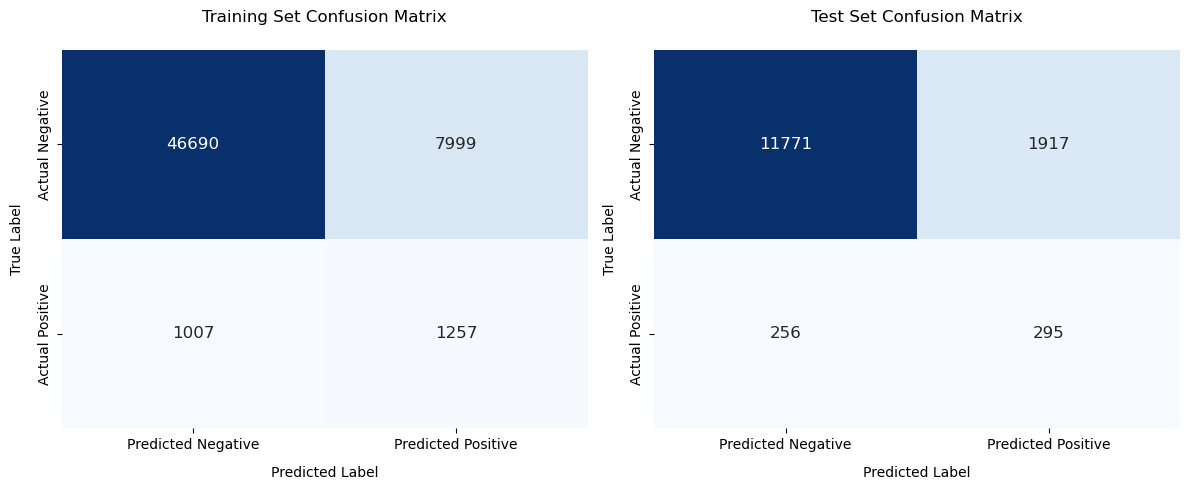

In [41]:
# Confusion Matrix (using 0.07 threshold as in original)
train_cm = confusion_matrix(y_train, (train_pred > 0.07).astype(int))
test_cm = confusion_matrix(y_test, (test_pred > 0.07).astype(int))
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, ax):
    # Create a DataFrame for better labeling
    cm_df = pd.DataFrame(cm, 
                        index=['Actual Negative', 'Actual Positive'],
                        columns=['Predicted Negative', 'Predicted Positive'])
    
    # Create heatmap
    sns.heatmap(cm_df, 
                annot=True,  # Show numbers in cells
                fmt='d',     # Format as integers
                cmap='Blues',  # Color scheme
                cbar=False,   # Remove color bar
                annot_kws={'size': 12},  # Size of numbers
                ax=ax)       # Specify axis
    
    # Customize
    ax.set_title(title, pad=20)
    ax.set_xlabel('Predicted Label', labelpad=10)
    ax.set_ylabel('True Label', labelpad=10)
    
    # Adjust layout
    plt.tight_layout()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot both confusion matrices
plot_confusion_matrix(train_cm, 'Training Set Confusion Matrix', ax1)
plot_confusion_matrix(test_cm, 'Test Set Confusion Matrix', ax2)

# Show the plot
plt.show()

In [42]:
# Print additional metrics for context
def print_metrics(cm, set_name):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\n{set_name} Metrics:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")

print_metrics(train_cm, "Training Set")
print_metrics(test_cm, "Test Set")


Training Set Metrics:
True Negatives: 46690
False Positives: 7999
False Negatives: 1007
True Positives: 1257
Accuracy: 0.842
Precision: 0.136
Recall: 0.555

Test Set Metrics:
True Negatives: 11771
False Positives: 1917
False Negatives: 256
True Positives: 295
Accuracy: 0.847
Precision: 0.133
Recall: 0.535


In [51]:
from sklearn.preprocessing import SplineTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
log_reg = LogisticRegression(max_iter=1000)  # Still increased for safety
pipeline = Pipeline([
    ('spline', spline),
    ('scaler', scaler),
    ('logreg', log_reg)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
spline_pred_train = pipeline.predict_proba(X_train)[:, 1]
spline_pred_test = pipeline.predict_proba(X_test)[:, 1]

In [52]:
# Evaluation
print("Spline Train AUC:", roc_auc_score(y_train, spline_pred_train))
print("Spline Test AUC:", roc_auc_score(y_test, spline_pred_test))
print("Spline Train Log Loss:", log_loss(y_train, spline_pred_train))
print("Spline Test Log Loss:", log_loss(y_test, spline_pred_test))

Spline Train AUC: 0.7925155304776053
Spline Test AUC: 0.7919662963359748
Spline Train Log Loss: 0.14529211776153256
Spline Test Log Loss: 0.1467976351518389


In [54]:
# Function to calculate lift
def calculate_lift(y_true, y_pred, n_bins=10):
    # Create a DataFrame with true labels and predictions
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    # Sort by predictions in descending order
    df = df.sort_values('y_pred', ascending=False)
    # Calculate total positives
    total_positives = df['y_true'].sum()
    total_count = len(df)
    # Bin into deciles (or n_bins)
    df['bin'] = pd.qcut(df['y_pred'], q=n_bins, duplicates='drop')
    # Group by bin
    lift_df = df.groupby('bin', observed=False).agg({
        'y_true': ['sum', 'count']
    }).reset_index()
    lift_df.columns = ['bin', 'positives', 'count']
    # Calculate cumulative positives and lift
    lift_df['cum_positives'] = lift_df['positives'].cumsum()
    lift_df['cum_count'] = lift_df['count'].cumsum()
    lift_df['lift'] = (lift_df['cum_positives'] / lift_df['cum_count']) / (total_positives / total_count)
    lift_df['percentile'] = (lift_df['cum_count'] / total_count) * 100
    return lift_df

In [56]:
# Calculate ROC curves
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss
fpr_train, tpr_train, _ = roc_curve(y_train, spline_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(y_test, spline_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

In [57]:
# Calculate Lift curves
lift_train = calculate_lift(y_train, spline_pred_train)
lift_test = calculate_lift(y_test, spline_pred_test)

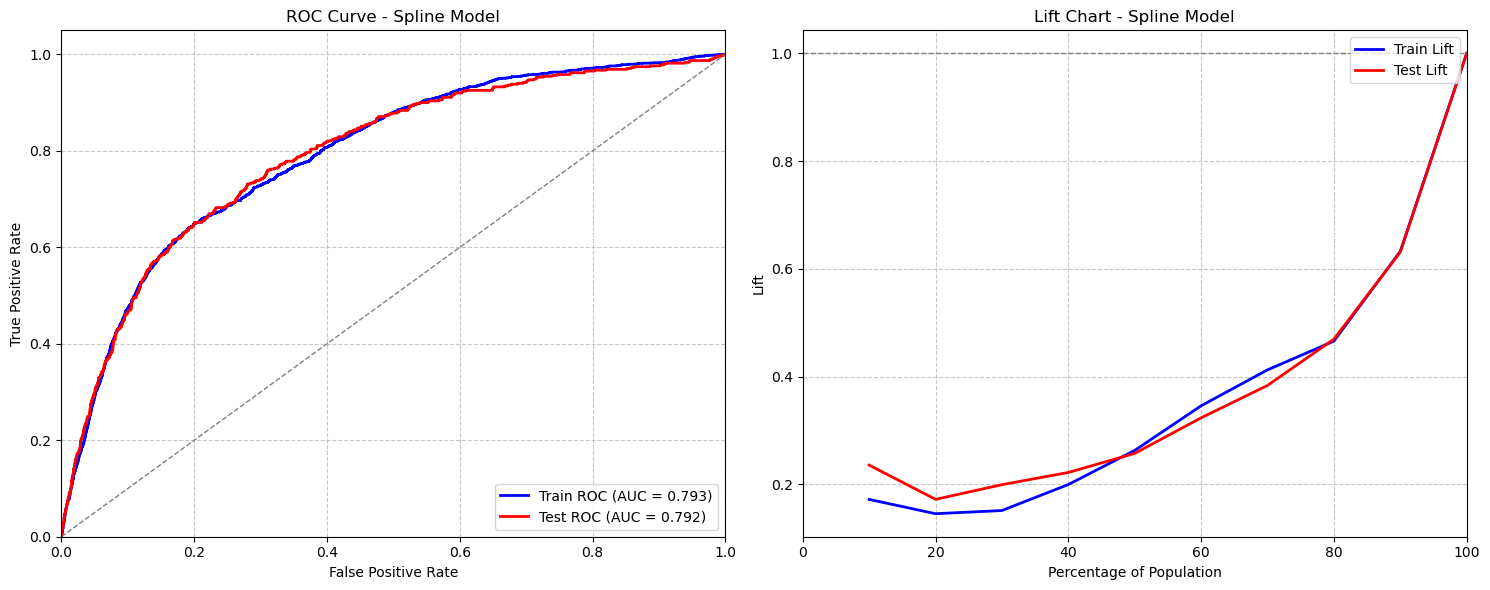

In [59]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Plot
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Train ROC (AUC = {roc_auc_train:.3f})')
ax1.plot(fpr_test, tpr_test, color='red', lw=2, 
         label=f'Test ROC (AUC = {roc_auc_test:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Spline Model')
ax1.legend(loc="lower right")
ax1.grid(True, linestyle='--', alpha=0.7)

# Lift Plot
ax2.plot(lift_train['percentile'], lift_train['lift'], color='blue', lw=2, 
         label='Train Lift')
ax2.plot(lift_test['percentile'], lift_test['lift'], color='red', lw=2, 
         label='Test Lift')
ax2.axhline(y=1, color='gray', lw=1, linestyle='--')
ax2.set_xlim([0, 100])
ax2.set_xlabel('Percentage of Population')
ax2.set_ylabel('Lift')
ax2.set_title('Lift Chart - Spline Model')
ax2.legend(loc="upper right")
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [60]:
# Print evaluation metrics
print("Spline Train AUC:", roc_auc_score(y_train, spline_pred_train))
print("Spline Test AUC:", roc_auc_score(y_test, spline_pred_test))
print("Spline Train Log Loss:", log_loss(y_train, spline_pred_train))
print("Spline Test Log Loss:", log_loss(y_test, spline_pred_test))

Spline Train AUC: 0.7925155304776053
Spline Test AUC: 0.7919662963359748
Spline Train Log Loss: 0.14529211776153256
Spline Test Log Loss: 0.1467976351518389


ROC (Receiver Operating Characteristic)
Definition: An ROC curve is like a report card for a prediction model. It shows how good the model is at telling the difference between two things—like whether someone will buy a product or not. Imagine you’re trying to guess which apples in a basket are sweet just by looking at them. The ROC curve plots how often you’re right about the sweet ones (catching the good apples) against how often you accidentally pick the sour ones (mistakes). The higher the curve climbs, the better your guesses are!

Key Idea: It’s about balancing "finding the good stuff" (sweet apples) while avoiding "picking the bad stuff" (sour apples).
Everyday Example: Think of a spam email filter. A good filter catches most spam (sweet apples) without flagging too many of your real emails (sour apples by mistake).

Lift
Definition: Lift is a way to measure how much better your model is at finding the "good stuff" compared to just guessing randomly. Picture a treasure hunt: if you dig randomly, you might find some gold eventually. But if you use a treasure map (your model), Lift tells you how many more treasures you find with the map than without it. A Lift of 2 means you’re twice as good as random guessing!

Key Idea: It shows the "boost" your model gives you over doing nothing special.
Everyday Example: Imagine calling people to sell cookies. If you call randomly, you might sell to 1 out of 10 people. With a good list of cookie lovers (your model), you might sell to 3 out of 10. That’s a Lift of 3—three times better than random!
Putting It Together
ROC: Helps you see how well your model separates "yes" from "no" overall.
Lift: Tells you how much more effective your model makes you at targeting the "yes" cases compared to no model at all.

What It Means
50% of the Population: Imagine you’ve ranked everyone by how likely your model thinks they’ll say "yes" (e.g., buy a product) and you’ve looked at the top half (50%) of that list.
Lift of 0.3: This tells you that, in that top 50%, your model is only 0.3 times as good as random guessing at finding the "yes" cases. Since 0.3 is less than 1, it’s not even as good as random—it’s less effective.

<Figure size 800x600 with 0 Axes>

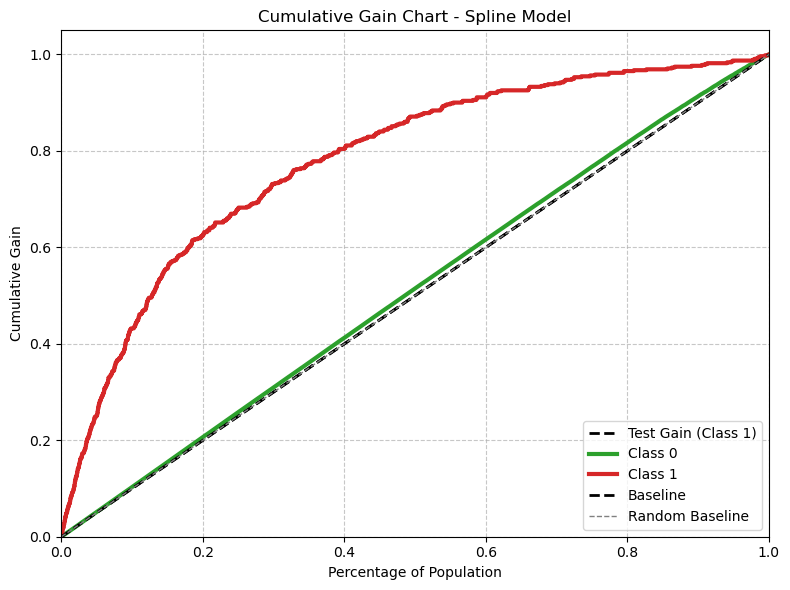

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt

# Predictions (probability of positive class)
spline_pred_train = pipeline.predict_proba(X_train)[:, 1]
spline_pred_test = pipeline.predict_proba(X_test)[:, 1]

# Create the cumulative gain plot
plt.figure(figsize=(8, 6))

# Create the cumulative gain plot
plt.figure(figsize=(8, 6))

# Plot for training data (Class 1 only)
skplt.metrics.plot_cumulative_gain(
    y_train, 
    pipeline.predict_proba(X_train),
    title=None,
    ax=plt.gca()
)
# Get the lines and modify labels (default plots both classes, we want Class 1)
lines = plt.gca().get_lines()
lines[1].set_label('Train Gain (Class 1)')  # Class 1 is typically the second line
lines[0].remove()  # Remove Class 0 line

# Plot for test data (Class 1 only)
skplt.metrics.plot_cumulative_gain(
    y_test, 
    pipeline.predict_proba(X_test),
    title=None,
    ax=plt.gca()
)
lines = plt.gca().get_lines()
lines[1].set_label('Test Gain (Class 1)')  # Class 1 line
lines[0].remove()  # Remove Class 0 line

# Add random baseline
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Baseline')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Percentage of Population')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart - Spline Model')
plt.legend(loc='lower right')  # Use Matplotlib's legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Overview of the Plot
X-Axis (Percentage of Population): This goes from 0% to 100% and represents how much of the total population you’re looking at, starting with the people the model thinks are most likely to be positive cases.
Y-Axis (Cumulative Gain): This shows the proportion of positive cases (e.g., buyers) you’ve captured, from 0 (none) to 1 (all of them).
Lines:
Test Gain (Class 1) (black solid line): Shows the cumulative gain for the test set’s positive class (Class 1).
Class 0 (green solid line): Shows the cumulative gain for the negative class (Class 0), which should ideally stay low.
Class 1 (red solid line): Shows the cumulative gain for the training set’s positive class (Class 1).
Random Baseline (gray dashed line): Represents what you’d get by randomly selecting people—e.g., if 20% of people are positive, you’d capture 20% of them by picking 20% randomly.
Interpretation
Shape of the Curves:
The black (Test Gain) and red (Class 1) lines rise steeply at first, then level off. This means the model is very good at finding most of the positive cases (Class 1) early on—by looking at just 20% of the population (top 20%), you capture about 80% of the positive cases!
The green line (Class 0) stays near the bottom, which is good—it means the model isn’t accidentally picking up too many negative cases when targeting positives.
Comparison to Random Baseline:
The gray dashed line (Random Baseline) goes straight from (0%, 0%) to (100%, 100%), meaning if you picked people randomly, you’d capture positives at the same rate as their overall proportion (e.g., if 30% of people are positive, you’d get 30% of them by picking 30%).
The black and red lines are much steeper, showing the model is far better than random guessing. For example, at 50% of the population, the model has captured over 90% of the positive cases, while random guessing would only get 50%.
Train vs. Test:
The red line (Train) and black line (Test) are close together, which is a good sign. It means the model performs similarly on the training data (data it learned from) and the test data (new data it hasn’t seen). This suggests the model isn’t just memorizing the training data but can generalize well.
Slight differences (e.g., Test might be a bit lower than Train) could indicate minor overfitting, but the closeness is generally positive.
Practical Meaning:
Early Gains: If you only have resources to target the top 20% of people (e.g., send marketing to 20% of your customer list), you’d capture about 80% of the potential buyers. This is a huge win compared to random selection!
Diminishing Returns: After about 50-60% of the population, the curve flattens, meaning you’re picking up fewer new positive cases as you go deeper. This suggests focusing efforts on the top half is most efficient.
Key Takeaways
Model Effectiveness: The Spline Model is excellent at ranking the positive cases (Class 1) at the top. You don’t need to look at everyone—just the top 20-30% to get most of the "good stuff."
Consistency: The model works well on both training and test data, so you can trust it with new people.
Better Than Random: It outperforms random guessing by a wide margin, making it a valuable tool for targeting.
Potential Concerns
The green line (Class 0) being visible suggests some negative cases are still mixed in, but since it’s low, it’s not a big issue.
If the test line dips below the train line significantly at any point, it might hint at overfitting, but here they’re quite aligned.
Actionable Insight
If you’re using this model for something like marketing, focus your efforts on the top 20-30% of the population ranked by the model’s scores—you’ll get most of the positive responses with less effort than contacting everyone!

Does this interpretation make sense? Let me know if you’d like me to focus on any specific part or adjust the explanation!